In [1]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pdb
from matplotlib import animation
%matplotlib notebook

In [2]:
class KF():
    
    def __init__(self, A, B, C, R, Q, init_guess, init_uncertainty):
        self.A = A
        self.B = B
        self.C = C
        self.R = R # covariance of system model
        self.Q = Q # covariance of measurements
        self.x = init_guess
        self.SIGMA = init_uncertainty
        self.I = np.eye(A.shape[0])
        self.last_time = 0
        print('Created KF Object')

    def predict(self,t,u):
        dt = t - self.last_time #get del_t
        self.last_time = t
        self.update_trans_mat(dt)

        self.x = self.A @ self.x + self.B @ u #update the belief mean 
        #(prior to measurement) 
        self.SIGMA = self.A @ self.SIGMA @ self.A.T + self.R #update the belief cov 
        #(prior to measurement) 
  
    def update(self, z):
        #z is 4 by 1 vector 
        temp_var = self.C @ self.SIGMA @ self.C.T + self.Q
        K_gain = self.SIGMA @ self.C.T @ np.linalg.inv(temp_var)
    
        self.x = self.x + K_gain@(z-self.C @ self.x) #update the belief mean 
        #(with measurement) 
        self.SIGMA = (self.I-K_gain@ self.C)@ self.SIGMA   #update the belief cov 
        #(with measurement) 
        return self.x, self.SIGMA #do I need to return this? (I dont think so) ##Yes 

    def update_trans_mat(self,dt):
        self.A[(0,1),(2,3)] = dt
        return None
  
    def KF_step(self, t, u, z):
        self.predict(t, u)
        temp_mu,temp_sigma = self.update(z)
        return temp_mu, temp_sigma  #return self.update(z), will this update the object then return or not?


class GT_Model(): #stands for grounf truth
    
    def __init__(self,A,B,C,R,Q,init_x):
        self.A = A
        self.B = B
        self.C = C
        self.R = R
        self.Q = Q
        self.last_time = 0
        self.x = init_x

        self.ZERO_S_MEAN = np.zeros([A.shape[0],1]) #the mean of the noise (state-transition model)
        self.ZERO_M_MEAN = np.zeros([C.shape[0],1]) #the mean of the noise (observation model)
        
    def update(self, t, u):
        dt = t-self.last_time
        self.last_time = t
        self.update_trans_mat(dt)
        #pdb.set_trace()
        self.x = self.A @ self.x \
                    + self.B @ u \
                    + np.diag(np.random.normal(loc=self.ZERO_S_MEAN,scale=self.R)).reshape([-1,1]) 
                # change this from a fixed number to a parameter 
        return self.x
    
    def measure(self):
        #pdb.set_trace()
        z = self.C @ self.x \
            + np.diag(np.random.normal(loc=self.ZERO_M_MEAN, scale=self.Q)).reshape([-1,1]) 
            # change this from a fixed number to a parameter 
        return z 
    
    def update_trans_mat(self, dt):
        self.A[(0,1),(2,3)] = dt
        return None


In [3]:
class simulator():
    
    def __init__(self, sim_time, step_size, KF, GT):
        self.sim_time = sim_time
        self.step_size = step_size
        self.num_step_points = int((sim_time-step_size)/step_size)
        self.t_vec = np.linspace(self.step_size,self.sim_time,self.num_step_points)
        self.GT = GT
        self.KF = KF
        self.true_x_h = []
        self.est_x_h = []
        self.est_cov_h = []
    
    def step(self, t, u):
        true_x = self.GT.update(t, u) 
        z = self.GT.measure()
        mu,sigma = self.KF.KF_step(t, u, z)
        return true_x, mu, sigma
        
    def sim_system(self, u_vec):
        # t=step_time 
        # since at t=0 the initial state is zero
        for i,t in enumerate(self.t_vec): #range(self.sim_time/self.step_time):
            true_x, mu, sigma = self.step(t,u_vec[:,i].reshape([-1,1]))
            self.true_x_h.append(true_x)
            self.est_x_h.append(mu)
            self.est_cov_h.append(sigma)


In [4]:
# define state-transition and observation models variables
A = np.eye(4)
B = np.concatenate((np.zeros([2,2]),np.eye(2)),axis=0)
C = np.concatenate((np.eye(2),np.zeros([2,2])),axis=1)

# define the motion and measurement noise covariance matrices 
R = 0.5*np.eye(4)
Q = 0.1*np.eye(2)
print(Q)

# define init pose and init guess
init_guess, init_cov = np.zeros([4,1]),np.random.rand(4,4) 
init_x = np.zeros([4,1])

# create Kalman Filter and Ground Truth Objects
KalmanFilter = KF(A, B, C, R*1000, Q, init_guess, init_cov)
GroundTruth = GT_Model(A, B, C, R, Q*2, init_x)

[[0.1 0. ]
 [0.  0.1]]
Created KF Object


In [5]:
# Create Simulation Object 
sim = simulator(1, 0.01, KalmanFilter, GroundTruth)

# create input signals 
ax = (np.ones((sim.t_vec.shape))*0.1).reshape([1,-1])
ay = 0.1*(np.cos((2*math.pi/sim.t_vec[-1])*sim.t_vec)).reshape([1,-1])

u_vec = np.concatenate([ax,ay],axis=0)

sim.sim_system(u_vec)

In [6]:
print(u_vec[:, 10])

[0.1        0.07664106]


<IPython.core.display.Javascript object>


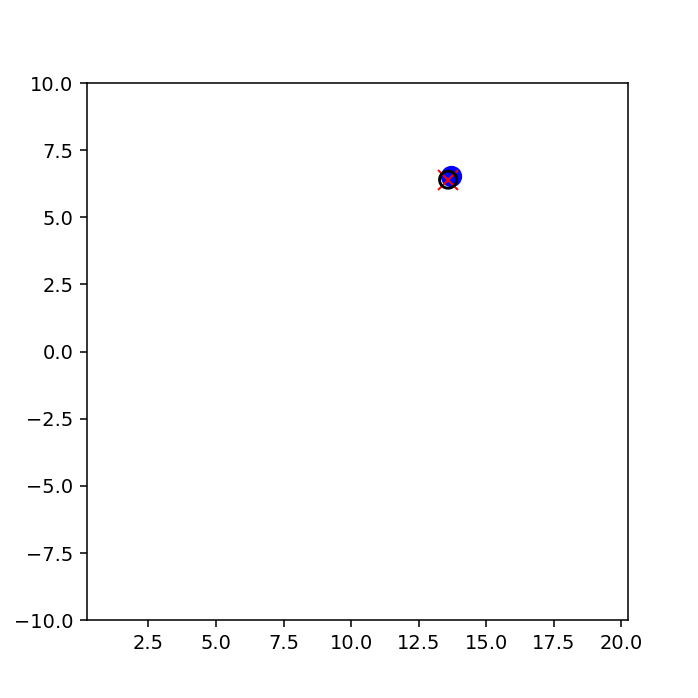

In [7]:
# simulation figure
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
true_pose, = ax.plot([1],[1],'bo', ms=10)
est_pose, = ax.plot([5],[5],'rx', ms=10)
cov_elipse_plot, = ax.plot([0,5,0,-5],[5,0,-5,0],'k', ms=7)

def cov_elipse(phi):
    a,b,c = phi[0,0], phi[0,1], phi[1,1] #since the diagonal elements are identical (symmetric matrix)
    term = np.sqrt(((a-c)/2)**2 + b**2)
    l1 = (a+c)/2+term
    l2 = (a+c)/2-term

    if b == 0:
        if a >= c:
            theta = 0
        else:
            theta = math.pi/2
    else:
        theta = math.atan2(l1-a,b)

    t = np.linspace(0,2*math.pi,50)
    x = math.sqrt(l1)*math.cos(theta)*np.cos(t)-math.sqrt(l2)*math.sin(theta)*np.sin(t)
    y = math.sqrt(l1)*math.sin(theta)*np.cos(t)+math.sqrt(l2)*math.cos(theta)*np.sin(t)
    return x, y


def update_fig(n):
    true_x_i = sim.true_x_h[n][0:2]
    est_x_i = sim.est_x_h[n][0:2]
    cov_mat_i = sim.est_cov_h[n][0:2,0:2]
    
    x, y = cov_elipse(cov_mat_i)
    #pdb.set_trace()

    true_pose.set_data(true_x_i[0],true_x_i[-1])
    est_pose.set_data(est_x_i[0],est_x_i[-1])
    cov_elipse_plot.set_data(x + est_x_i[0], y + est_x_i[-1])

    #setting the axis limit 
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    x, y = true_x_i[0], true_x_i[-1]

    if x > x_max or x < x_min :
        ax.set_xlim(x-10, x+10)
    if y > y_max or y < y_min :
        ax.set_ylim(y-10, y+10)

    return (true_pose, est_pose)

anim = animation.FuncAnimation(fig, update_fig, frames=sim.num_step_points, interval=500, blit=True)
plt.show()

In [9]:
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = '/home/pengxia/anaconda3/bin/ffmpeg'

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()  

In [10]:
anim.save('mountiancar.gif', writer='Pillow') # save the animation as a gif (located in this folder)

MovieWriter Pillow unavailable; using Pillow instead.
